This notebook uses DEM elevations to make a mask for the mountains.

This notebook was copied and edited on 3-31-23.

***

Import things. Use conda environment oliviaJupyter.

In [1]:
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Load the DEM and crop it to small unwrapped region.

In [2]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/geom_reference'

# size of full res SLCs (same as DEM)
dxIN=18000
dyIN=3600

file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(0,0,dxIN,dyIN)
box = np.zeros((5,2))
x1 = 17000; x2 = 14000; dx = x1-x2
y1 = 1750;  y2 = 1000;  dy = y1-y2
box[0] = [x1,y1]; box[1] = [x2,y1]
box[2] = [x2,y2]; box[3] = [x1,y2]; box[4] = box[0]
elev_cropped = elev[y2:y1,x2:x1]

print('DEM loaded + cropped.')

DEM loaded + cropped.


Mask it based on being below certain elevation. 

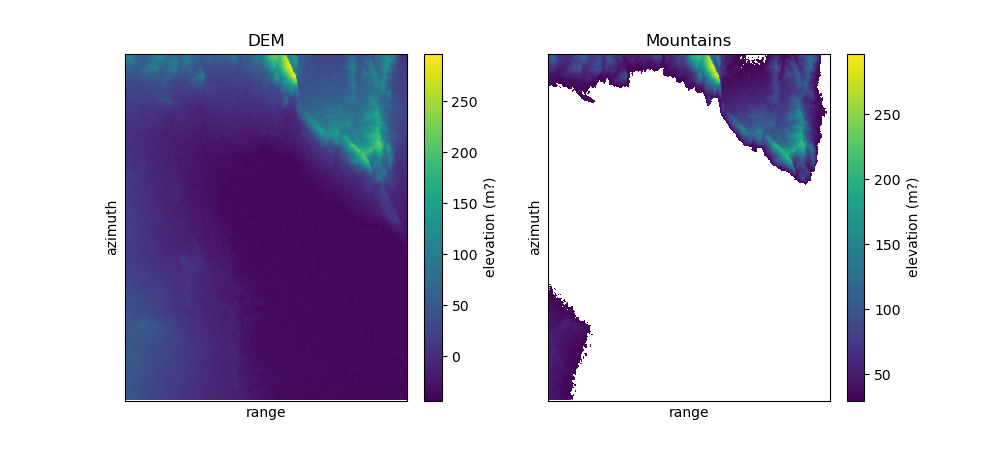

In [4]:
elev_masked_mtns = np.ma.masked_where(elev_cropped<30,elev_cropped)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.imshow(elev_cropped, cmap='viridis',interpolation='nearest',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('DEM'); plt.colorbar(label='elevation (m?)')
plt.subplot(1,2,2)
plt.imshow(elev_masked_mtns, cmap='viridis',interpolation='nearest',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Mountains'); plt.colorbar(label='elevation (m?)')
plt.show()

Now make array to be saved as the LS mask.

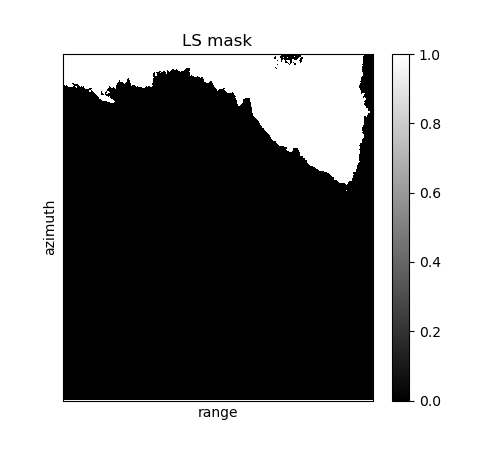

In [5]:
mask_y,mask_x = np.nonzero(elev_masked_mtns)
mtns_mask = np.zeros((dy,dx))
mtns_mask[mask_y,mask_x] = 1.0
mtns_mask[400::,:] = 0.0

# plot it to make sure it matches plot above.
plt.figure(figsize=(5,4.5))
plt.imshow(mtns_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('LS mask') 
plt.colorbar(); plt.show()

In [6]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
# set the folder to save this mask file to
saveDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/'
save_file_name = 'mtns_mask.r4'
colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(mtns_mask)
colds=None
print('Mask of mountains saved.')

Mask of mountains saved.
